In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from salishsea_tools import (nc_tools,viz_tools,bathy_tools,tidetools,geo_tools)
import matplotlib.cm as cm
import scipy.io
import os
import datetime as dt
import drifter

import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.7, rc={"lines.linewidth": 2.5})
%matplotlib inline

In [2]:
grid1 = nc.Dataset('/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc')
grid2 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc','r')
bath = {}; lons = {};lats = {}
for grid,na in zip([grid1,grid2],['bathy2','bathy6']):
    bathy, X, Y = tidetools.get_bathy_data(grid)
    lats[na] = grid.variables['nav_lat']
    lons[na] = grid.variables['nav_lon']
    bath[na] = grid.variables['Bathymetry']

In [3]:
## load drifter
drifters = scipy.io.loadmat('/ocean/mhalvers/research/drifters/SoG_drifters.mat',squeeze_me=True)
ubc = drifters['ubc']

* load particle

In [4]:
drop = 'drop1/12'
runs=['oct8_10Onehour','oct8_10reduceviscosityOnehour']
strings = ['Baseline','LongRiver+LowerViscosity']
base='/ocean/jieliu/research/meopar/Ariane/result/'
file_pattern = 'ariane_trajectories_qualitative.nc'
lon112 = {}; lat112={}; d = {}
for run, string in zip(runs,strings):
    path = os.path.join(base,run, drop,file_pattern)
    f = nc.Dataset(path,'r');
    lon112[string] = f.variables['traj_lon']
    lat112[string] = f.variables['traj_lat']
    d[string] = {}

In [5]:
drop = 'drop1/3'
runs=['oct8_10Onehour','oct8_10reduceviscosityOnehour']
strings = ['Baseline','LongRiver+LowerViscosity']
base='/ocean/jieliu/research/meopar/Ariane/result/'
file_pattern = 'ariane_trajectories_qualitative.nc'
lon13 = {}; lat13={};
for run, string in zip(runs,strings):
    path = os.path.join(base,run, drop,file_pattern)
    f = nc.Dataset(path,'r');
    lon13[string] = f.variables['traj_lon']
    lat13[string] = f.variables['traj_lat']

* build functions

In [6]:
namelists = ['112a','112b','13','212a','212b','23','31a','31b','323']
for string in strings:
    for name in namelists:
        d[string][name] = []

In [7]:
def calculate_distance(d,textname, na, strings,lon112,lat112,duration,name):
    """
    textname: e.g., 112a.txt
    na: bathy2 or 6
    strings: specify run case
    lon112: specify which run particle
    duration: if 0, then name should contain letter 'a', if not 0, then 'b'
    name: e.g., 112a, 112b and etc
    return: distance between drifter and particle after every one hour for a specific run case, like 'Baseline'
    """
    file = np.loadtxt(textname)
    for string in strings:
        for i in range(1, len(file)):
            distance= geo_tools.haversine(lons[na][file[i,1]-1,file[i,0]-1], lats[na][file[i,1]-1,file[i,0]-1],
                                   lon112[string][1,i-1+duration],lat112[string][1,i-1+duration])
            #print(string, name)
            d[string][name].append(distance)
    return d

In [8]:
d = calculate_distance(d, '112a.txt','bathy6',strings, lon112,lat112,0,'112a')
d = calculate_distance(d, '112b.txt','bathy6',strings, lon112,lat112,28,'112b')
d = calculate_distance(d, '13.txt','bathy6',strings, lon13,lat13,0,'13')

In [9]:
sum_number = {};mean_distance = {};stde_distance = {}
for string in strings:
    sum_number[string] = []
    mean_distance[string] = []
    stde_distance[string] = []

In [10]:
s = {}
each_item = {}
for string in strings:
    s[string] = 0
    each_item[string] = []
    for key in d[string].keys():
        sum_number[string].append(len(d[string][key])) ## sum up numbers of distances in each particle
        for distance in d[string][key]:
            s[string] = s[string]+ distance
            each_item[string].append(distance)
        
    mean_distance[string] = s[string]/sum(sum_number[string])
    stde_distance[string] = np.std(each_item[string])/np.sqrt(sum(sum_number[string]))

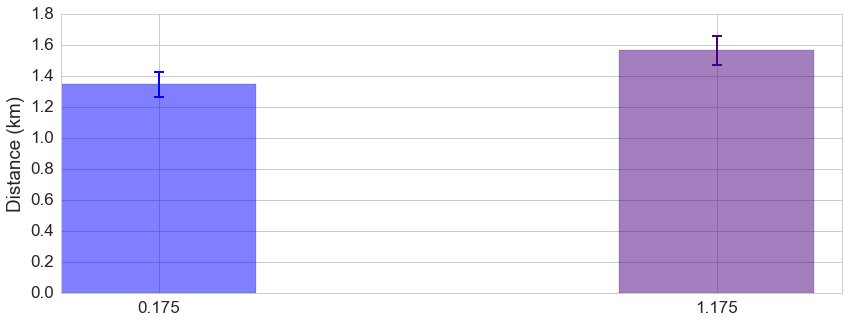

In [13]:
fig,ax = plt.subplots(1,1,figsize = (14,5))

mean_dists = [mean_distance['Baseline'],mean_distance['LongRiver+LowerViscosity']]
ind = np.arange(len(mean_dists))
width = 0.35
number = len(d['Baseline']['112a'])

colors = ['b','Indigo','SeaGreen','r']
std_dists = [stde_distance['Baseline'],stde_distance['LongRiver+LowerViscosity']]
diff_dist = ax.bar(ind, mean_dists, width,color=colors,alpha=0.5)
for pos, y, err, color in zip(ind, mean_dists, std_dists, colors):
    ax.errorbar(pos+width/2, y, err, lw=2, capsize=5, capthick=2, color=color)
ax.set_ylabel('Distance (km)')
ax.set_xticks(ind+width/2)
#ax.set_xticklabels('Baseline', 'Lower Viscosity' )
plt.show()

In [22]:
na = 'bathy6'
file = np.loadtxt('112a.txt')
for string in strings:
    for i in range(1, len(file)):
        distance= geo_tools.haversine(lons[na][file[i,1]-1,file[i,0]-1], lats[na][file[i,1]-1,file[i,0]-1],
                               lon112[string][1,i-1],lat112[string][1,i-1])
        d[string]['112a'].append(distance)
        #print(i,file[i,1]-1, file[i,0]-1, d)



Baseline 1.41087468902
0.0749905908345
LongRiver+LowerViscosity 1.33234940789
0.0717323681372
